In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error




fred = fr.Fred(api_key=fred_api_key)



YENUSD = fred.get_series("DEXJPUS")
YENUSD.name = "YENUSD"

df = pd.concat([YENUSD],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)





device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


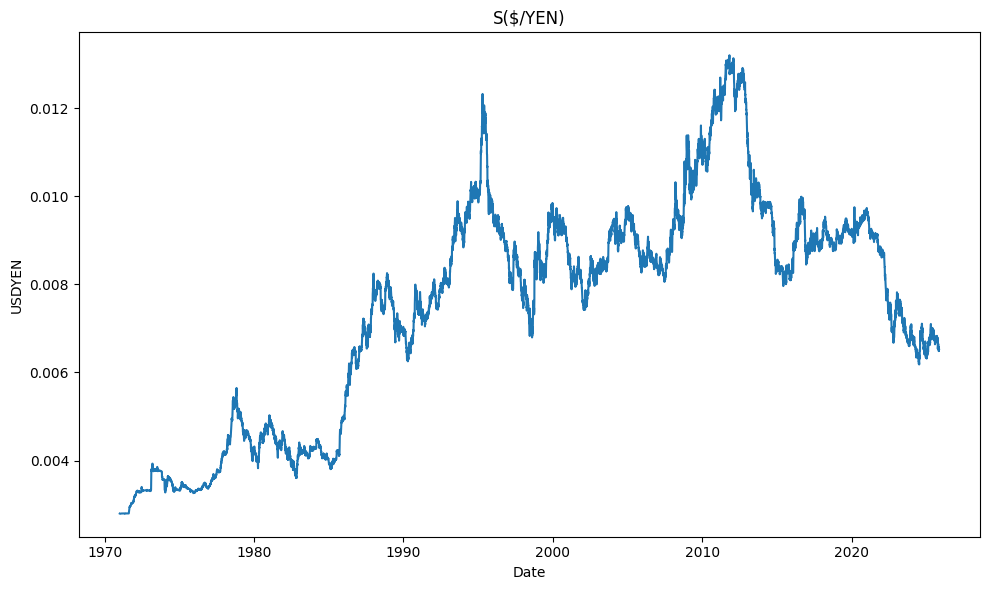

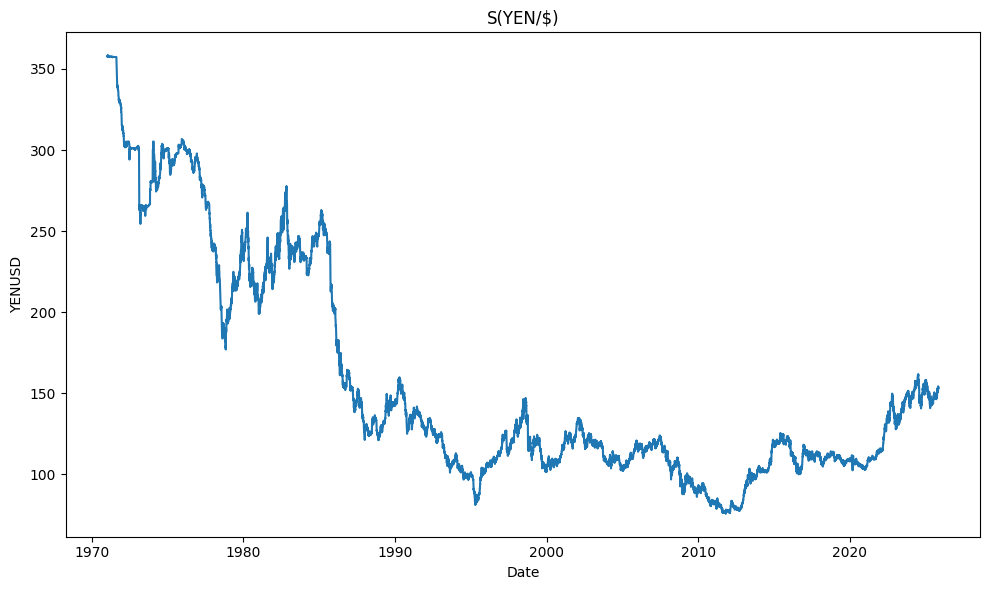

In [2]:
#direct
df['USDYEN']  = 1 / df['YENUSD']

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y="USDYEN",data=df)
plt.title("S($/YEN)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y="YENUSD",data=df)
plt.title("S(YEN/$)")
plt.tight_layout()
plt.show()

In [3]:

df.drop("YENUSD",inplace=True,axis=1)
df.drop_duplicates(inplace=True)

training = df.iloc[:,1:2].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def sliding_window(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = sliding_window(train_scaled,seq_length)
X_test,y_test = sliding_window(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class BiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=1, output_size=1):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = BiLSTM()
epochs = 250
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')



/tmp/ipykernel_14401/1385327646.py:83: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_14401/1385327646.py:85: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.4468; Test RMSE: 0.4075
Epoch: 1; train_RMSE: 0.4122; Test RMSE: 0.3681
Epoch: 2; train_RMSE: 0.3763; Test RMSE: 0.3262
Epoch: 3; train_RMSE: 0.3383; Test RMSE: 0.2802
Epoch: 4; train_RMSE: 0.2981; Test RMSE: 0.2283
Epoch: 5; train_RMSE: 0.2574; Test RMSE: 0.1697
Epoch: 6; train_RMSE: 0.224; Test RMSE: 0.1102
Epoch: 7; train_RMSE: 0.218; Test RMSE: 0.09692
Epoch: 8; train_RMSE: 0.2473; Test RMSE: 0.1547
Epoch: 9; train_RMSE: 0.2617; Test RMSE: 0.1806
Epoch: 10; train_RMSE: 0.2481; Test RMSE: 0.1633
Epoch: 11; train_RMSE: 0.225; Test RMSE: 0.1281
Epoch: 12; train_RMSE: 0.2072; Test RMSE: 0.09699
Epoch: 13; train_RMSE: 0.1998; Test RMSE: 0.08394
Epoch: 14; train_RMSE: 0.1998; Test RMSE: 0.08839
Epoch: 15; train_RMSE: 0.2029; Test RMSE: 0.09912
Epoch: 16; train_RMSE: 0.2056; Test RMSE: 0.1084
Epoch: 17; train_RMSE: 0.2062; Test RMSE: 0.1135
Epoch: 18; train_RMSE: 0.204; Test RMSE: 0.1138
Epoch: 19; train_RMSE: 0.199; Test RMSE: 0.1094
Epoch: 20; train_RMSE: 0.1914;

In [5]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


# Root-Mean Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Root Mean Squared Error: {rmse:.4f}")

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}')


# root mean average 
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Average Percentage Error: {mape:.4}')


test_dates = df.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

Root Mean Squared Error: 0.0001
R2 Score: 99.56
Mean Average Percentage Error: 0.007509
         Date  Actual Spot Rate  Predicted Spot Rate
0  2020-05-19          0.009269             0.009340
1  2020-05-20          0.009306             0.009321
2  2020-05-21          0.009286             0.009327
3  2020-05-22          0.009302             0.009322
4  2020-05-26          0.009290             0.009315
5  2020-05-27          0.009277             0.009307
6  2020-05-28          0.009288             0.009300
7  2020-05-29          0.009279             0.009295
8  2020-06-01          0.009297             0.009297
9  2020-06-02          0.009208             0.009295
10 2020-06-03          0.009184             0.009283
11 2020-06-04          0.009174             0.009269
12 2020-06-05          0.009117             0.009254
13 2020-06-08          0.009220             0.009231
14 2020-06-09          0.009289             0.009224
15 2020-06-10          0.009324             0.009221
16 2020-06-

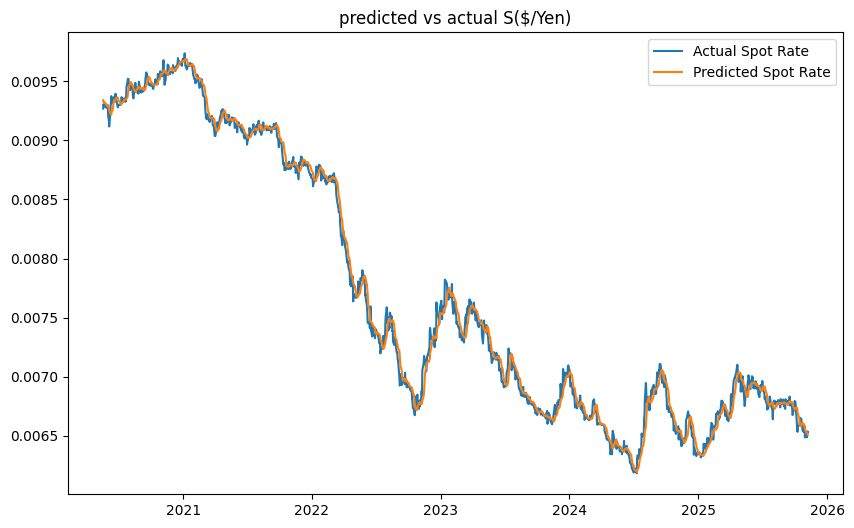

In [7]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual S($/Yen)")
plt.legend()
plt.show()